> Created on Thu Jul  9 22:10:09 2020  @author: Richie Bao-caDesign设计(cadesign.cn)

## 1 核密度估计与地理空间点密度分布
### 1.1 核密度估计
#### 1.1.1 单变量（一维数组）的核密度估计
当直方图的组距无限缩小至极限后，能够拟合出一条曲线，计算这个分布曲线的公式即为概率密度函数（Probability Density Function,PDF），这是在[正态分布](https://richiebao.github.io/Urban-Spatial-Data-Analysis_python/#/./notebook_code/normalDis_PDF_outliers)一节中所阐述的内容，而用于估计概率密度函数的非参数方法就是核密度估计。核密度估计（Kernel density estimation, KDE）是一个基本的数据平滑问题（a fundamental data smoothing problem），例如对不平滑的直方图平滑，给定一个核K, 并指定带宽（bandwidth），其值为正数，核密度估计定义为： $\hat{f} _{n} (x)= \frac{1}{nh}  \sum_{i=1}^n {K( \frac{x- x_{i} }{h} )} $，其中K为核函数，$h$为带宽，核函数有多个，例举其中高斯核为：$\frac{1}{ \sqrt{2 \pi } }  e^{- \frac{1}{2}  x^{2} } $，将其带入核密度估计公式结果为：$\hat{f} _{n} (x)= \frac{1}{ \sqrt{2 \pi } nh}  \sum_{i=1}^n { e^{ -\frac{ (x- x_{i} )^{2} }{2 h^{2} } } } $。

在下述代码中绘制了三条曲线，红色粗线为概率密度函数；两条细线均为核密度估计（高斯核），只是蓝色线是依据核密度公式直接编写代码，并设置带宽h=0.4；绿色线则是使用scipy库下的`stats.gaussian_kde()`方法计算高斯核密度估计。

> 非参数统计（Nonparametric Statistics）是统计的一个分支，但不是完全基于参数化的概率分布,例如通过参数均值和方差（或标准差）定义一个正态分布，非参数统计基于自由分布（distribution-free）或指定的分布但未给分布参数，例如当处理PDF的一般情况时，不能像正态分布那样给定参数进行分类。其基本思想是在尽可能少的假定时，利用数据对一个未知量做出推断，通常意味着利用具有无穷维的统计模型。 

> 对于核密度估计名词中密度一词可以形象理解为下图中橄榄绿小竖线的分布密度。

参考：Wikipedia以及 Larry Wasserman.All of nonparametric statistics.Springer (October 21, 2005),中文版为：[美]Larry Wasserman.吴喜之译.现代非参数统计[M].可续出版社,北京.2008.5；Urmila Diwekar,Amy David.Bonus algorithm for large scale stochastic nonlinear programming problems.Springer; 2015 edition (March 5, 2015)

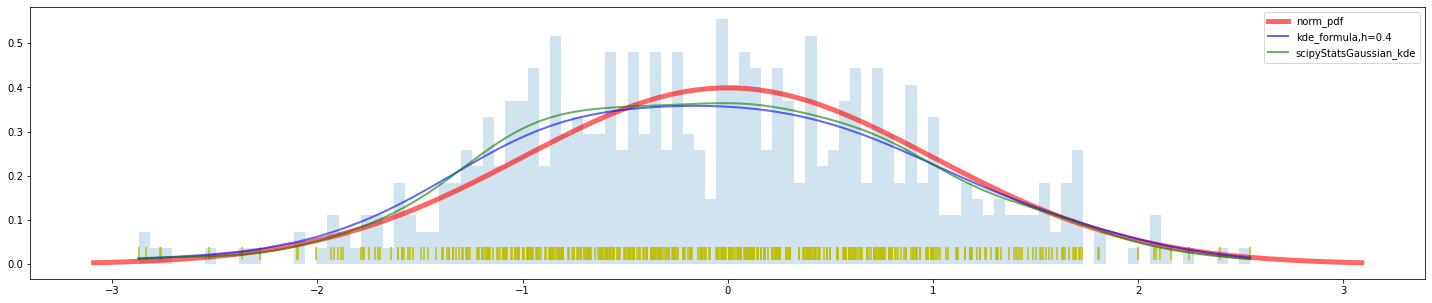

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
x=np.linspace(stats.norm.ppf(0.001,loc=0,scale=1),stats.norm.ppf(0.999,loc=0,scale=1), 100) #如果不给参数loc和scale,则默认为标准正态分布，即loc=0, scale=1
pdf=stats.norm.pdf(x)

plt.figure(figsize=(25,5))
plt.plot(x,pdf,'r-', lw=5, alpha=0.6, label='norm_pdf')

random_variates=stats.norm.rvs(loc=0,scale=1,size=500)
count, bins, ignored =plt.hist(random_variates,bins=100,density=True,histtype='stepfilled',alpha=0.2)
plt.eventplot(random_variates,color='y',linelengths=0.03,lineoffsets=0.025)

rVar_sort=np.sort(random_variates)
h=0.4
n=len(rVar_sort)
kde_Gaussian=[sum(math.exp(-1*math.pow(vi-vj,2)/(2*math.pow(h,2))) for vj in rVar_sort)/(h*n*math.sqrt(2*math.pi)) for vi in rVar_sort] #将上述高斯核密度估计公式转换为代码
plt.plot(rVar_sort,kde_Gaussian,'b-', lw=2, alpha=0.6, label='kde_formula,h=%s'%h)

scipyStatsGaussian_kde=stats.gaussian_kde(random_variates)
plt.plot(bins,scipyStatsGaussian_kde(bins),'g-', lw=2, alpha=0.6, label='scipyStatsGaussian_kde')
plt.legend()
plt.show()

带宽（bandwidth）影响光滑的程度，下述实验设置不同的值，观察核密度曲线的变化情况。关于最适宜的带宽推断，<em>Bonus algorithm for large scale stochastic nonlinear programming problems</em>第3章，<em>Probability Density Function and Kernel Density Estimation</em>一节中提到一种方法。

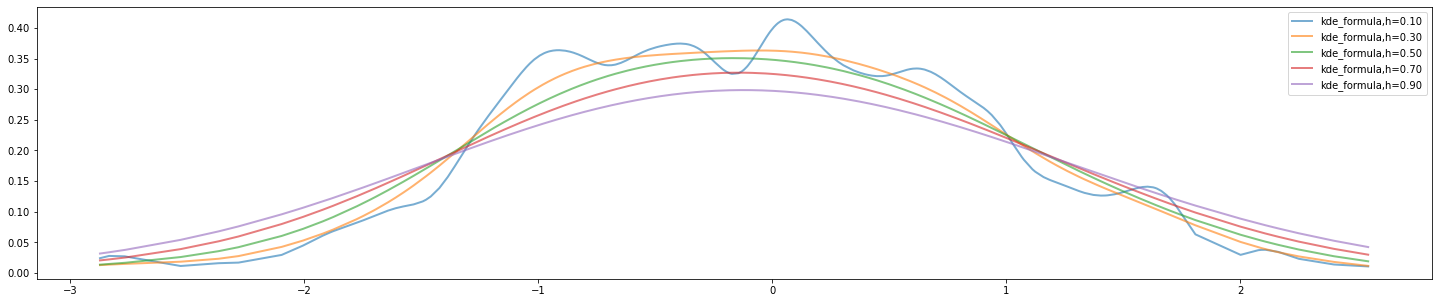

In [7]:
bws=np.arange(0.1,1,0.2)
colors_kde=['C{}'.format(i) for i in range(len(bws))] #maplotlib库颜色映射
i=0
plt.figure(figsize=(25,5))
for h in bws:
    kde_Gaussian=[sum(math.exp(-1*math.pow(vi-vj,2)/(2*math.pow(h,2))) for vj in rVar_sort)/(h*n*math.sqrt(2*math.pi)) for vi in rVar_sort] #将上述高斯核密度估计公式转换为代码
    plt.plot(rVar_sort,kde_Gaussian,color=colors_kde[i], lw=2, alpha=0.6, label='kde_formula,h=%.2f'%h)
    i+=1
plt.legend()
plt.show()

#### 1.1.2 多变量（多维数组）的核密度估计
核密度估计可以平滑多维数据，例如热力图的制作是基于核密度估计的二维平滑，以爬取的POI数据为例，直接使用`scipy.stats.gaussian_kde()`计算其核密度，一是计算所有点的核密度估计；二是提取一级分类为'美食'（delicacy）的行，计算美食的核密度估计。

C:\Users\richi\conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

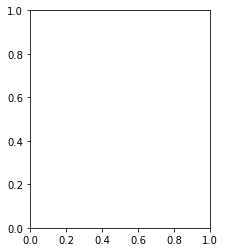

In [10]:
import pandas as pd
poi_gpd=pd.read_pickle('./data/poiAll_gpd.pkl') #读取已经存储为.pkl格式的POI数据，其中包括geometry字段，为GeoDataFrame地理信息数据，可以通过poi_gpd.plot()迅速查看数据。
poi_gpd_clean=poi_gpd.dropna()
poi_gpd_clean.plot(marker=".",markersize=5,column='detail_info_price') #查看POI数据是否读取正常
poi_gpd_clean.head()

In [9]:
poi_gpd_clean=poi_gpd.dropna()

* 所有POI点数据的核密度估计，并建立地图

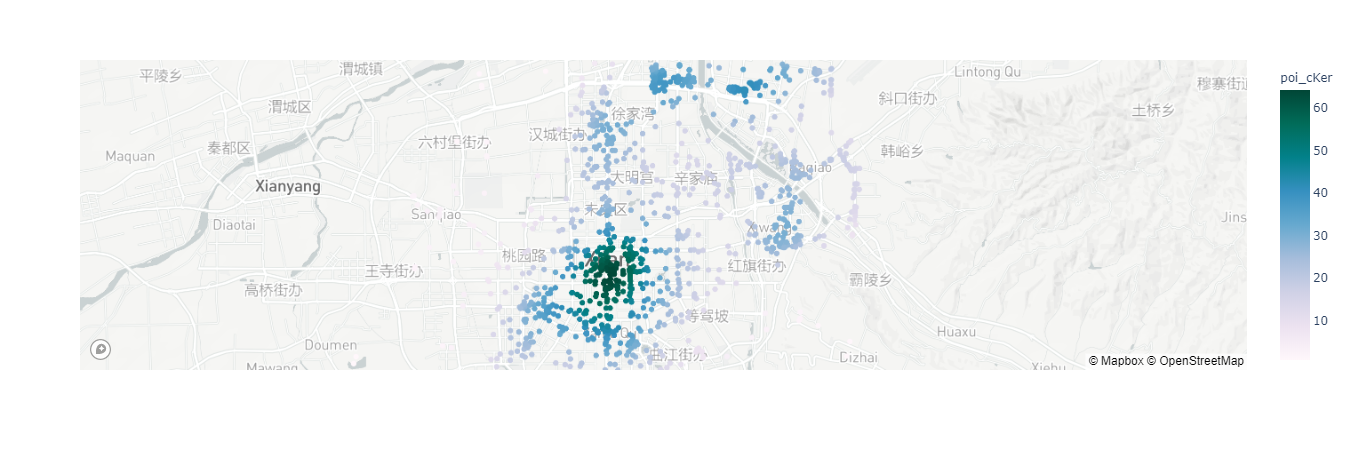

In [287]:
poi_coordinates=poi_gpd[['location_lng','location_lat']].to_numpy().T 
poi_coordi_kernel=stats.gaussian_kde(poi_coordinates) #核密度估计
poi_gpd['poi_cKer']=poi_coordi_kernel(poi_coordinates)

import plotly.express as px
poi_gpd.detail_info_price=poi_gpd.detail_info_price.fillna(0) 
mapbox_token='pk.eyJ1IjoicmljaGllYmFvIiwiYSI6ImNrYjB3N2NyMzBlMG8yc254dTRzNnMyeHMifQ.QT7MdjQKs9Y6OtaJaJAn0A'
px.set_mapbox_access_token(mapbox_token)
fig=px.scatter_mapbox(poi_gpd,lat=poi_gpd.location_lat, lon=poi_gpd.location_lng,color='poi_cKer',color_continuous_scale=px.colors.sequential.PuBuGn, size_max=15, zoom=10) #亦可以选择列，通过size=""配置增加显示信息
fig.show()

* '美食'位置点分布的核密度估计

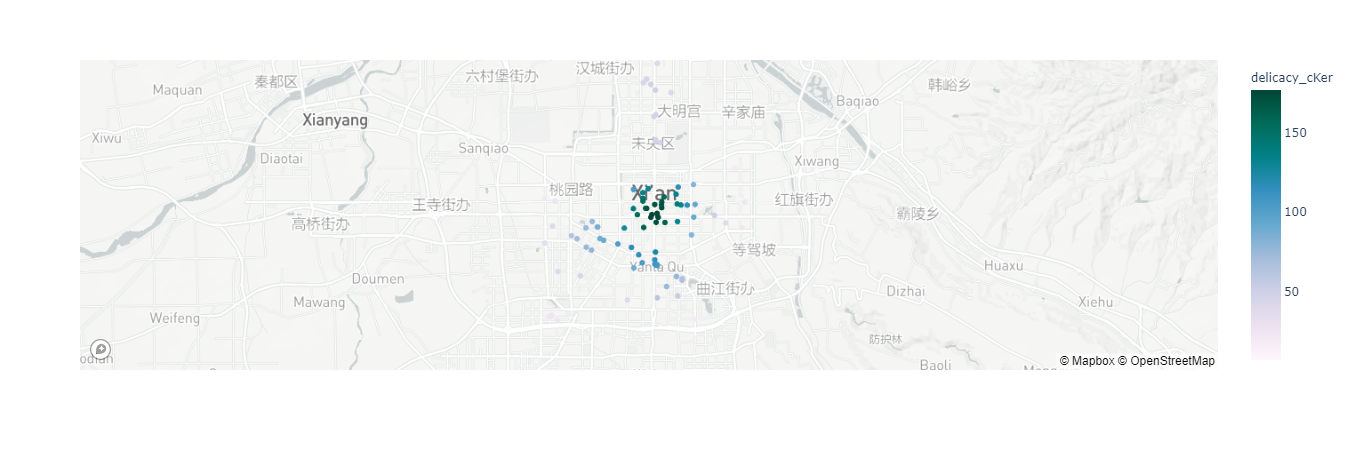

In [310]:
poi_gpd['tag_primary']=poi_gpd['detail_info_tag'].apply(lambda row:str(row).split(";")[0])
poi_classificationName={
        "美食":"delicacy",
        "酒店":"hotel",
        "购物":"shopping",
        "生活服务":"lifeService",
        "丽人":"beauty",
        "旅游景点":"spot",
        "休闲娱乐":"entertainment",
        "运动健身":"sports",
        "教育培训":"education",
        "文化传媒":"media",
        "医疗":"medicalTreatment",
        "汽车服务":"carService",
        "交通设施":"trafficFacilities",
        "金融":"finance",
        "房地产":"realEstate",
        "公司企业":"corporation",
        "政府机构":"government",
        'nan':'nan'
        }
poi_gpd.loc[:,["tag_primary"]]=poi_gpd["tag_primary"].replace(poi_classificationName)
delicacy_df=poi_gpd.loc[poi_gpd.tag_primary=='delicacy']
delicacy_coordi=delicacy_df[['location_lng','location_lat']].to_numpy().T 
delicacy_kernel=stats.gaussian_kde(delicacy_coordi) #核密度估计
delicacy_df['delicacy_cKer']=delicacy_kernel(delicacy_coordi)

import plotly.express as px
poi_gpd.detail_info_price=poi_gpd.detail_info_price.fillna(0) 
mapbox_token='pk.eyJ1IjoicmljaGllYmFvIiwiYSI6ImNrYjB3N2NyMzBlMG8yc254dTRzNnMyeHMifQ.QT7MdjQKs9Y6OtaJaJAn0A'
px.set_mapbox_access_token(mapbox_token)
fig=px.scatter_mapbox(delicacy_df,lat=delicacy_df.location_lat, lon=delicacy_df.location_lng,color='delicacy_cKer',color_continuous_scale=px.colors.sequential.PuBuGn, size_max=15, zoom=10) #亦可以选择列，通过size=""配置增加显示信息
fig.show()

## 1.2 核密度估计结果转换为地理栅格数据

In [4]:
import geopandas as gpd
from pyproj import Proj, CRS,transform
from pyproj import Transformer
print(poi_gpd.crs)
poi_gpd_c=poi_gpd.copy(deep=True)
poi_gpd_c.to_crs(CRS("EPSG:32649"))
print(poi_gpd_c.crs)

NameError: name 'poi_gpd' is not defined

In [334]:

#convert points .shp to raster 将点数据写入为raster数据。使用raster.SetGeoTransform,栅格化数据。参考GDAL官方代码
def pts2raster(shapefile,RASTER_PATH,cellSize,field_name=False):
    from osgeo import gdal, ogr

    # Define pixel_size and NoData value of new raster
    pixel_size = cellSize
    NoData_value = -9999
    
    # Filename of input OGR file
    vector_ptsShp_fn = shapefile
    
    # Filename of the raster Tiff that will be created
    raster_ptsShp_fn = RASTER_PATH
    
    # Open the data source and read in the extent
    source_ds = ogr.Open(vector_ptsShp_fn)
    source_layer = source_ds.GetLayer()
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
    
    # Create the destination data source
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)
    target_ds = gdal.GetDriverByName('GTiff').Create(raster_ptsShp_fn, x_res, y_res, 1, gdal.GDT_Int32 )
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)
    
    # Rasterize
    # gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[0])
    # Rasterize
    if field_name:
        gdal.RasterizeLayer(target_ds,[1], source_layer,options=["ATTRIBUTE={0}".format(field_name)])
        # print("write:",field_name)
    else:
        gdal.RasterizeLayer(target_ds,[1], source_layer,burn_values=[-1])   
    return gdal.Open(RASTER_PATH).ReadAsArray()


ValueError: Length of values does not match length of index

In [335]:
xy.T

array([[109.06845869, 109.06845869, 109.06845869, 109.06845869,
        109.01845869, 109.01845869, 109.01845869, 109.01845869,
        108.96845869, 108.96845869, 108.96845869, 108.96845869,
        108.91845869, 108.91845869, 108.91845869, 108.91845869,
        108.86845869, 108.86845869, 108.86845869, 108.86845869,
        108.81845869, 108.81845869, 108.81845869, 108.81845869,
        108.76845869, 108.76845869, 108.76845869, 108.76845869],
       [ 34.18229608,  34.23229608,  34.28229608,  34.33229608,
         34.18229608,  34.23229608,  34.28229608,  34.33229608,
         34.18229608,  34.23229608,  34.28229608,  34.33229608,
         34.18229608,  34.23229608,  34.28229608,  34.33229608,
         34.18229608,  34.23229608,  34.28229608,  34.33229608,
         34.18229608,  34.23229608,  34.28229608,  34.33229608,
         34.18229608,  34.23229608,  34.28229608,  34.33229608]])

In [359]:
from pyproj import Transformer

In [3]:
gpd.__version__

'0.8.0'

In [325]:
lat_grid

array([34.18229608, 34.23229608, 34.28229608, 34.33229608])

In [329]:
lng_grid.shape

(7,)

In [6]:
poi_gpd.head()

name  location_lat  location_lng detail_info_tag  \
poi_0_delicacy 0         御荷苑饭店     34.182148    108.823310          美食;中餐厅   
               2         一品轩餐厅     34.183155    108.823328          美食;中餐厅   
               4         老米家泡馍     34.183547    108.823851          美食;中餐厅   
               6  关中印象咥长安(创汇店)     34.183542    108.823498          美食;中餐厅   
               8      惠记葫芦头梆梆肉     34.183534    108.823589          美食;中餐厅   

                  detail_info_overall_rating detail_info_price  \
poi_0_delicacy 0                         4.0               NaN   
               2                         5.0               NaN   
               4                         5.0               NaN   
               6                         4.5                 8   
               8                         4.6               NaN   

                                    geometry  
poi_0_delicacy 0  POINT (108.82331 34.18215)  
               2  POINT (108.82333 34.18316)  
               4  POINT (108.82385 34.18355)  
               6  POINT (108.82350 34.18354)  
               8  POINT (108.82359 34.18353)